<a href="https://colab.research.google.com/github/Harish-topper12/Deep_Learning_Assignment/blob/main/CNN_Assignment2_Updated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# -----------------------------
# Importing required TensorFlow and Keras packages

# TensorFlow-specific imports
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import l2

# Base Keras imports
import keras
from keras import backend as K
from keras.utils import to_categorical
from keras.models import Sequential

# For model optimization, training strategies, and callbacks
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler

# Layers specific to convolutional neural networks (CNNs)
from keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout

# For image data augmentation and preprocessing
from keras.preprocessing.image import ImageDataGenerator

# Additional utility and visualization imports
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

# Dataset-specific imports
from keras.datasets import cifar10

# For splitting and handling data
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
# -----------------------------


In [2]:
# Displaying the installed version of TensorFlow
print(tf.__version__)

# Displaying the installed version of Keras
print(keras.__version__)

2.14.0
2.14.0


### Loading and Splitting CIFAR-10 dataset

In [3]:
# Loading the CIFAR-10 dataset into training and test sets
(x_train_full, y_train_full), (x_test, y_test) = cifar10.load_data()

# Splitting the original training data into training and validation sets
# Using stratification to ensure that the validation set has the same class distribution as the original training set
x_train, x_val, y_train, y_val = train_test_split(x_train_full, y_train_full, test_size = 0.2, random_state = 42, stratify = y_train_full)

170498071/170498071 [==============================] - 6s 0us/step


In [4]:
# Displaying the shape of the training dataset (number of samples and image dimensions)
print(f"Training set shape: {x_train.shape}")

# Displaying the shape of the validation dataset (number of samples and image dimensions)
print(f"Validation set shape: {x_val.shape}")

# Displaying the shape of the test dataset (number of samples and image dimensions)
print(f"Test set shape: {x_test.shape}")


Training set shape: (40000, 32, 32, 3)
Validation set shape: (10000, 32, 32, 3)
Test set shape: (10000, 32, 32, 3)


#### Displaying Random Images from trained dataset

In [5]:
cifar10_classes = ["airplane", "automobile", "bird", "cat", "deer",
                   "dog", "frog", "horse", "ship", "truck"]

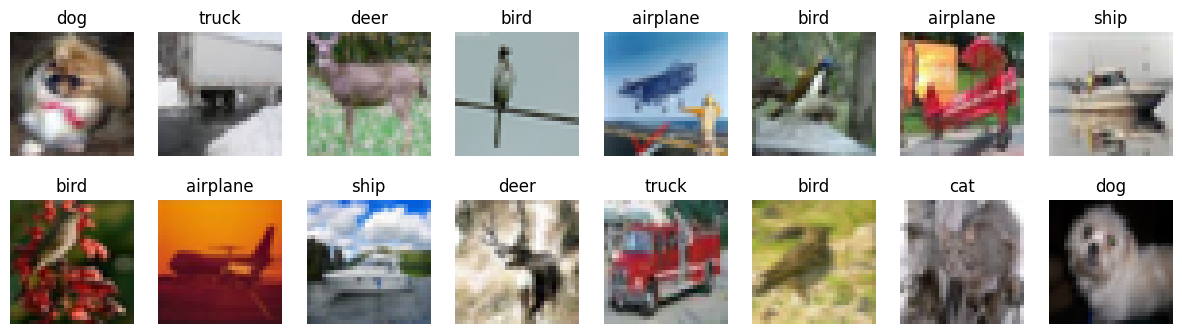

In [6]:
# Show random images from train
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 2.5 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_train))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_train[random_index, :])
        ax.set_title(cifar10_classes[y_train[random_index, 0]])
plt.show()

### One - Hot Encoding on target values

In [7]:
# Converting the training labels to one-hot encoded vectors
y_train = to_categorical(y_train)

# Converting the test labels to one-hot encoded vectors
y_test = to_categorical(y_test)

# Converting the validation labels to one-hot encoded vectors
y_val = to_categorical(y_val)

In [8]:
# Verifying the one-hot encoding of the training labels
print(y_train)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]]


#### Normalizing Scaled Data

In [9]:
# Converting the training data to float type and normalizing it to the range [0, 1]
x_train = x_train.astype('float32')
x_train = x_train/255.0

# Converting the validation data to float type and normalizing it to the range [0, 1]
x_val = x_val.astype('float32')
x_val = x_val/255.0

# Converting the test data to float type and normalizing it to the range [0, 1]
x_test = x_test.astype('float32')
x_test = x_test/255.0

### Model Diagnostics & Insights

In [10]:
def summarize_diagnostics(history):
    """
    Visualizes the training history: plots the training and validation loss and accuracy.

    Parameters:
    - history : Training history object generated by the `fit` method of a Keras model.

    Returns:
    - None. Displays the plot.
    """

    # Set up a 2x1 grid of subplots
    plt.figure(figsize=(10, 6))  # You can adjust this for better visualization as needed

    # ----------------
    # Plotting the loss over epochs
    # ----------------

    plt.subplot(211)  # The top subplot for loss visualization

    # Setting title and plotting the training and validation loss
    plt.title('Cross Entropy Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='orange', label='test')

    # Adding x and y axis labels
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    # Displaying the legend to differentiate between training and validation loss
    plt.legend(loc='upper right')

    # ----------------
    # Plotting the accuracy over epochs
    # ----------------

    plt.subplot(212)  # The bottom subplot for accuracy visualization

    # Setting title and plotting the training and validation accuracy
    plt.title('Classification Accuracy')
    plt.plot(history.history['accuracy'], color='blue', label='train')
    plt.plot(history.history['val_accuracy'], color='orange', label='test')

    # Adding x and y axis labels
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')

    # Displaying the legend to differentiate between training and validation accuracy
    plt.legend(loc='upper left')

    # Adjusting the layout to ensure non-overlapping
    plt.tight_layout()

    # Show the plots
    plt.show()

In [11]:
def top3_class_accuracies(model,x_test = x_test, test_labels = y_test):
    # Load CIFAR-10 data

    test_labels = np.argmax(test_labels, axis=1)

    test_labels = test_labels.squeeze()  # Remove single-dimensional entries



    # Get model predictions for the test set
    predicted_classes = np.argmax(model.predict(x_test), axis=1)

    # CIFAR-10 class names
    class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

    # Calculate accuracy for each class
    class_accuracies = {}
    for i, class_name in enumerate(class_names):
        correct_predictions = np.sum((test_labels == i) & (predicted_classes == i))
        total = np.sum(test_labels == i)
        class_accuracies[class_name] = correct_predictions / total

    # Sort and select top 3 classes
    sorted_accuracies = sorted(class_accuracies.items(), key=lambda x: x[1], reverse=True)[:3]

    return sorted_accuracies

In [12]:
def plot_top3_accuracies(model, arch_name):
    """
    Plots the top 3 class accuracies for a given model and architecture name.

    Parameters:
    - model : Trained Keras model to evaluate.
    - arch_name : String representing the architecture or model name, for display purposes.

    Returns:
    - None. Displays a bar plot of the top 3 class accuracies.
    """

    # Use the previously defined function to get the top 3 class accuracies for the given model
    top3_accuracies = top3_class_accuracies(model, x_test=x_test, test_labels=y_test)

    # Print the top 3 class accuracies for reference
    print(top3_accuracies)

    # Extract class names and their corresponding accuracies from the result for plotting
    classes, accuracies = zip(*top3_accuracies)

    # Set up the bar plot for the top 3 class accuracies
    bars = plt.bar(classes, accuracies, color=['blue', 'green', 'red'])
    plt.xlabel('Classes')         # Label for the x-axis
    plt.ylabel('Accuracy')        # Label for the y-axis
    plt.title(f'Top 3 Class Accuracies for {arch_name}')  # Title for the plot, using the provided architecture name
    plt.ylim(0, 1)                # Set the y-axis limits to [0, 1] to represent accuracy range
    plt.tight_layout()           # Adjust the layout to ensure non-overlapping of elements

    # Display the plot
    plt.show()

In [13]:
def get_top_3_misclassifications(model, x_test, y_test):
    """
    Identifies the top 3 classes that are most frequently misclassified by a given model.

    Parameters:
    - model : Trained Keras model.
    - x_test : Test data.
    - y_test : Ground truth labels for the test data (expected to be in integer format).

    Returns:
    - results : List of tuples. Each tuple contains two misclassified class names and the count of misclassifications.
    """

    # Define the CIFAR-10 class labels for reference
    classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

    # Convert the one-hot encoded ground truth labels to class indices
    y_true = np.squeeze(y_test)  # Remove any unwanted dimensions, if present

    # Get the model's predicted class probabilities and then convert them to class indices
    y_pred = model.predict(x_test)
    y_pred = np.argmax(y_pred, axis=1)

    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # List to store misclassification details
    misclassifications = []

    # Remove the diagonal of the confusion matrix since it represents the count of correct predictions
    np.fill_diagonal(cm, 0)

    # Iterate over the confusion matrix to identify misclassifications
    for i in range(10):
        for j in range(10):
            if i != j:
                misclassifications.append((i, j, cm[i][j]))

    # Sort the misclassifications in descending order based on counts and take the top 3
    top_3_misclassifications = sorted(misclassifications, key=lambda x: x[2], reverse=True)[:3]

    # Prepare the results using class names instead of indices
    results = []
    for i, j, count in top_3_misclassifications:
        results.append((classes[i], classes[j], count))

    return results

#### VGG-inspired Baseline Model

In [14]:
def vgg_based_cifar10_baseline_model():
    """
    Construct a VGG-inspired model for CIFAR-10 classification.

    Returns:
    - A compiled Keras model suitable for the CIFAR-10 dataset.
    """
    model = Sequential()

    # Block 1: Two convolutional layers followed by max-pooling
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))

    # Block 2: Two convolutional layers followed by max-pooling with increased filters
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))

    # Block 3: Two convolutional layers followed by max-pooling with even more filters
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))

    # Fully connected layers: Flattening followed by dense layers
    model.add(Flatten())
    model.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))

    # Output layer with softmax activation for multi-class classification
    model.add(Dense(10, activation='softmax'))  # CIFAR-10 has 10 classes

    # Compile the model using SGD optimizer and categorical cross-entropy loss
    optimizer = SGD(learning_rate=0.001, momentum=0.9)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [15]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
vgg_cifar10_baseline_model = vgg_based_cifar10_baseline_model()
vgg_history = vgg_cifar10_baseline_model.fit(x_train, y_train, epochs=50, validation_data=(x_val, y_val), callbacks = [early_stopping])

Epoch 1/50
1250/1250 [==============================] - 18s 6ms/step - loss: 1.7257 - accuracy: 0.3765 - val_loss: 1.4902 - val_accuracy: 0.4634
Epoch 2/50
1250/1250 [==============================] - 6s 5ms/step - loss: 1.3628 - accuracy: 0.5113 - val_loss: 1.2963 - val_accuracy: 0.5332
Epoch 3/50
1250/1250 [==============================] - 6s 5ms/step - loss: 1.1701 - accuracy: 0.5850 - val_loss: 1.1443 - val_accuracy: 0.5992
Epoch 4/50
1250/1250 [==============================] - 6s 5ms/step - loss: 1.0171 - accuracy: 0.6430 - val_loss: 1.0197 - val_accuracy: 0.6455
Epoch 5/50
1250/1250 [==============================] - 6s 5ms/step - loss: 0.9021 - accuracy: 0.6849 - val_loss: 0.9773 - val_accuracy: 0.6630
Epoch 6/50
1250/1250 [==============================] - 6s 5ms/step - loss: 0.7982 - accuracy: 0.7197 - val_loss: 0.9246 - val_accuracy: 0.6818
Epoch 7/50
1250/1250 [==============================] - 6s 5ms/step - loss: 0.7140 - accuracy: 0.7512 - val_loss: 0.8931 - val_accuracy

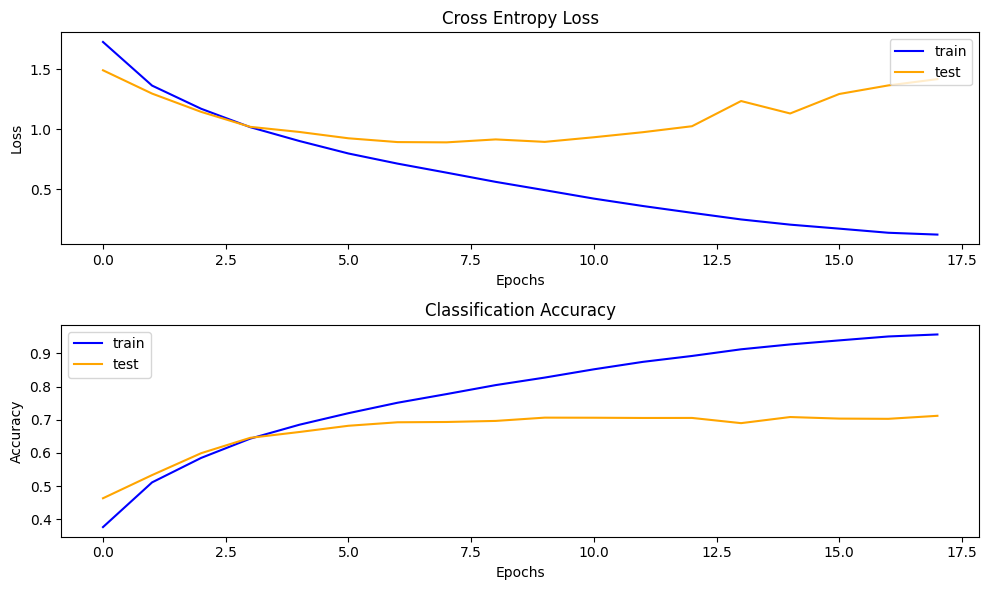

In [16]:
summarize_diagnostics(vgg_history)

In [17]:
vgg_train_loss, vgg_train_accuracy = vgg_cifar10_baseline_model.evaluate(x_train, y_train)
vgg_train_accuracy

1250/1250 [==============================] - 4s 3ms/step - loss: 0.5553 - accuracy: 0.8135


0.8135499954223633

In [18]:
vgg_val_loss, vgg_val_accuracy = vgg_cifar10_baseline_model.evaluate(x_val, y_val)
vgg_val_accuracy

313/313 [==============================] - 1s 3ms/step - loss: 0.8908 - accuracy: 0.6932


0.6931999921798706

In [19]:
vgg_test_loss, vgg_test_accuracy = vgg_cifar10_baseline_model.evaluate(x_test, y_test)
vgg_test_accuracy

313/313 [==============================] - 1s 3ms/step - loss: 0.8856 - accuracy: 0.6983


0.6983000040054321

### Insights from the Graph of the Baseline Model:

**Based on the visual data:**

1. We notice a steady rise in training accuracy, yet the test accuracy seems to stagnate. This indicates that our model might be becoming too tailored to the training dataset and struggles to adapt to unfamiliar data, leading to overfitting.

2. The test set's Cross Entropy Loss is significantly elevated, with a clear distinction between the losses observed during training and testing.

**Considering these insights, strategies for model enhancement include:**

i) To address the generalization issue, we aim to integrate data augmentation and regularization strategies like dropout.

ii) To potentially boost test accuracy, we're considering adding another VGG block.

iii) Incorporating Batch Normalization might stabilize the deep network's training by ensuring a more uniform distribution for each layer's inputs.

#### Enhanced VGG with Data Augmentation

In [20]:
def vgg_cifar10_augmented_with_extra_blocks():
    """
    This function defines a VGG-inspired architecture for CIFAR-10 classification.
    This model has two additional VGG blocks compared to the baseline, making it deeper.
    The design is intended to be used in combination with data augmentation techniques
    to improve generalization over the dataset.
    """
    model = Sequential()

    # Block 1
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))

    # Block 2
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))

    # Block 3
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))

    # Block 4 - New Block
    model.add(Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))

    # Fully connected layers
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(10, activation='softmax'))  # Assuming 10 classes

    optimizer = SGD(learning_rate=0.001, momentum=0.9)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model


In [21]:
vgg_cifar10_model = vgg_cifar10_augmented_with_extra_blocks()

datagen = datagen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    shear_range=0.,
    zoom_range=0.,
    vertical_flip=False,
    fill_mode='nearest',
    cval=0.,
    rescale=None,
    # set function that will be applied on each input
    preprocessing_function=None,
    data_format=None
)

# prepare iterator
it_train = datagen.flow(x_train, y_train, batch_size=32)
# fit model
steps = int(x_train.shape[0] / 32)

early_stopping = EarlyStopping(monitor='val_loss', patience=10)

vgg_history = vgg_cifar10_model.fit(it_train, steps_per_epoch=steps, epochs=100, validation_data=(x_val, y_val), callbacks = [early_stopping])

Epoch 1/100
1250/1250 [==============================] - 24s 18ms/step - loss: 1.7782 - accuracy: 0.3490 - val_loss: 1.4862 - val_accuracy: 0.4616
Epoch 2/100
1250/1250 [==============================] - 22s 17ms/step - loss: 1.4756 - accuracy: 0.4649 - val_loss: 1.3168 - val_accuracy: 0.5153
Epoch 3/100
1250/1250 [==============================] - 22s 18ms/step - loss: 1.3248 - accuracy: 0.5240 - val_loss: 1.1731 - val_accuracy: 0.5851
Epoch 4/100
1250/1250 [==============================] - 23s 19ms/step - loss: 1.2099 - accuracy: 0.5663 - val_loss: 1.1161 - val_accuracy: 0.6103
Epoch 5/100
1250/1250 [==============================] - 22s 18ms/step - loss: 1.1153 - accuracy: 0.6033 - val_loss: 1.0046 - val_accuracy: 0.6460
Epoch 6/100
1250/1250 [==============================] - 22s 18ms/step - loss: 1.0385 - accuracy: 0.6306 - val_loss: 1.0959 - val_accuracy: 0.6164
Epoch 7/100
1250/1250 [==============================] - 22s 18ms/step - loss: 0.9661 - accuracy: 0.6568 - val_loss: 0

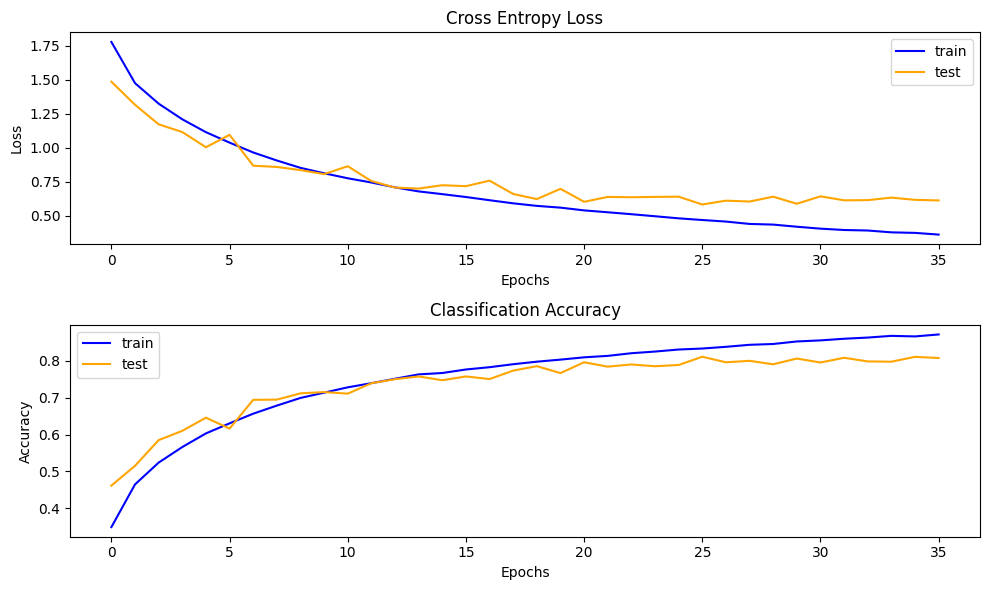

In [22]:
summarize_diagnostics(vgg_history)

In [23]:
vgg_train_accuracy = vgg_cifar10_model.evaluate(x_train, y_train)
vgg_train_accuracy

1250/1250 [==============================] - 4s 3ms/step - loss: 0.2899 - accuracy: 0.8986


[0.28985515236854553, 0.8986250162124634]

In [24]:
vgg_val_accuracy = vgg_cifar10_model.evaluate(x_val, y_val)
vgg_val_accuracy

313/313 [==============================] - 1s 3ms/step - loss: 0.6138 - accuracy: 0.8079


[0.6138020157814026, 0.8079000115394592]

In [25]:
vgg_test_accuracy = vgg_cifar10_model.evaluate(x_test, y_test)
vgg_test_accuracy

313/313 [==============================] - 1s 3ms/step - loss: 0.6321 - accuracy: 0.8077


[0.632087767124176, 0.807699978351593]

#### Insights from the graph of enhanced VGG with Data Augmentation Model

1. Compared to the baseline model, the validation and test accuracy have improved by over 8%. Additionally, the reduced gap between training and validation/test accuracy indicates a decrease in overfitting compared to the baseline model.

2. Despite these improvements, the accuracy is still not satisfactory, and there's room to further mitigate overfitting. To address this, we plan to introduce batch normalization to each VGG block of this model to boost accuracy. Furthermore, we will incorporate dropout in conjunction with batch normalization to further curb overfitting.

In [26]:
def vgg_cifar10_dropout_batch_normalization():
    model = Sequential()

    # Block 1
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))




    # Block 2
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))





    # Block 3
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.4))

    # Block 4 - New Block
    model.add(Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.4))






    # Fully connected layers
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(10, activation='softmax'))  # Assuming 10 classes


    optimizer = SGD(learning_rate=0.001, momentum=0.9)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [27]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
vgg_cifar10_dropout_batch_normalization_model = vgg_cifar10_dropout_batch_normalization()
vgg_history = vgg_cifar10_dropout_batch_normalization_model.fit(x_train, y_train, epochs=100, validation_data=(x_val, y_val), callbacks = [early_stopping])

Epoch 1/100
1250/1250 [==============================] - 11s 7ms/step - loss: 1.8332 - accuracy: 0.3356 - val_loss: 1.7593 - val_accuracy: 0.3868
Epoch 2/100
1250/1250 [==============================] - 8s 6ms/step - loss: 1.4664 - accuracy: 0.4600 - val_loss: 1.3509 - val_accuracy: 0.5140
Epoch 3/100
1250/1250 [==============================] - 8s 6ms/step - loss: 1.3135 - accuracy: 0.5206 - val_loss: 1.2057 - val_accuracy: 0.5596
Epoch 4/100
1250/1250 [==============================] - 8s 7ms/step - loss: 1.1997 - accuracy: 0.5679 - val_loss: 1.2981 - val_accuracy: 0.5535
Epoch 5/100
1250/1250 [==============================] - 8s 6ms/step - loss: 1.1165 - accuracy: 0.5990 - val_loss: 1.0343 - val_accuracy: 0.6320
Epoch 6/100
1250/1250 [==============================] - 8s 6ms/step - loss: 1.0485 - accuracy: 0.6224 - val_loss: 1.0152 - val_accuracy: 0.6308
Epoch 7/100
1250/1250 [==============================] - 8s 6ms/step - loss: 0.9869 - accuracy: 0.6451 - val_loss: 0.9267 - val_a

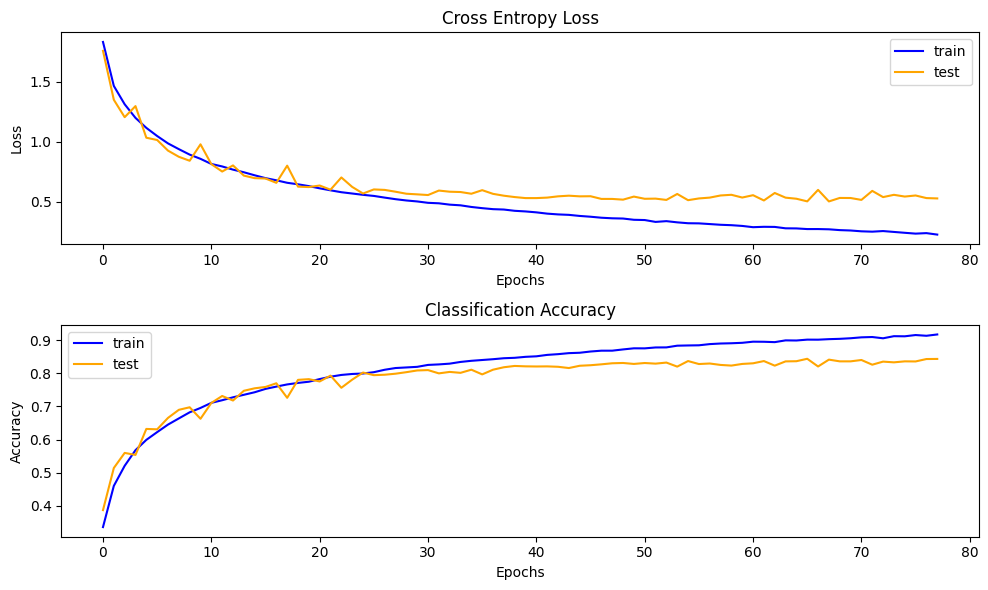

In [28]:
summarize_diagnostics(vgg_history)

In [29]:
vgg_train_accuracy = vgg_cifar10_dropout_batch_normalization_model.evaluate(x_train, y_train)
vgg_train_accuracy

1250/1250 [==============================] - 4s 3ms/step - loss: 0.0617 - accuracy: 0.9863


[0.061699140816926956, 0.9863499999046326]

In [30]:
vgg_val_accuracy = vgg_cifar10_dropout_batch_normalization_model.evaluate(x_val, y_val)
vgg_val_accuracy

313/313 [==============================] - 1s 3ms/step - loss: 0.5026 - accuracy: 0.8413


[0.5026403069496155, 0.8413000106811523]

In [31]:
vgg_test_accuracy = vgg_cifar10_dropout_batch_normalization_model.evaluate(x_test, y_test)
vgg_test_accuracy

313/313 [==============================] - 1s 3ms/step - loss: 0.5387 - accuracy: 0.8397


[0.538749635219574, 0.8396999835968018]

#### Baseline + Data Augmentation + Drop out, Batch Normalization

In [ ]:
datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
# prepare iterator
it_train = datagen.flow(x_train, y_train, batch_size=64)
# fit model
steps = int(x_train.shape[0] / 64)

early_stopping = EarlyStopping(monitor='val_loss', patience=10)

vgg_history = vgg_cifar10_dropout_batch_normalization_model.fit(it_train, steps_per_epoch=steps, epochs=100, validation_data=(x_val, y_val), callbacks = [early_stopping])

Epoch 1/100
625/625 [==============================] - 22s 33ms/step - loss: 0.6366 - accuracy: 0.7925 - val_loss: 0.5875 - val_accuracy: 0.8129
Epoch 2/100
625/625 [==============================] - 21s 33ms/step - loss: 0.6069 - accuracy: 0.7935 - val_loss: 0.5577 - val_accuracy: 0.8155
Epoch 3/100
625/625 [==============================] - 20s 33ms/step - loss: 0.5775 - accuracy: 0.8021 - val_loss: 0.5639 - val_accuracy: 0.8149
Epoch 4/100
625/625 [==============================] - 20s 32ms/step - loss: 0.5569 - accuracy: 0.8064 - val_loss: 0.5112 - val_accuracy: 0.8295
Epoch 5/100
625/625 [==============================] - 20s 33ms/step - loss: 0.5581 - accuracy: 0.8083 - val_loss: 0.5273 - val_accuracy: 0.8224
Epoch 6/100
625/625 [==============================] - 20s 32ms/step - loss: 0.5467 - accuracy: 0.8094 - val_loss: 0.5450 - val_accuracy: 0.8147
Epoch 7/100
625/625 [==============================] - 21s 33ms/step - loss: 0.5329 - accuracy: 0.8110 - val_loss: 0.4933 - val_ac

In [ ]:
lenet_train_accuracy = lenet_cifar10_model.evaluate(x_train, y_train)
lenet_train_accuracy

In [ ]:
lenet_val_accuracy = lenet_cifar10_model.evaluate(x_val, y_val)
lenet_val_accuracy

In [ ]:
lenet_test_accuracy = lenet_cifar10_model.evaluate(x_test, y_test)
lenet_test_accuracy

In [ ]:
plot_top3_accuracies(lenet_cifar10_model, arch_name = "Lenet Architecture")

In [ ]:
get_top_3_misclassifications("Lenet Architecture", alexnet_cifar10_model, x_test, y_test)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_accuracies_comparison(architectures, train_accuracies, val_accuracies, test_accuracies):
    barWidth = 0.25
    r1 = np.arange(len(train_accuracies))
    r2 = [x + barWidth for x in r1]
    r3 = [x + barWidth for x in r2]

    # Create train accuracy bars
    plt.bar(r1, train_accuracies, width=barWidth, color='blue', edgecolor='grey', label='train')

    # Create validation accuracy bars
    plt.bar(r2, val_accuracies, width=barWidth, color='cyan', edgecolor='grey', label='validation')

    # Create test accuracy bars
    plt.bar(r3, test_accuracies, width=barWidth, color='red', edgecolor='grey', label='test')

    # Title & Subtitle
    plt.title('Comparison of Architectures')

    # X axis
    plt.xlabel('Architectures', fontweight='bold')
    plt.xticks([r + barWidth for r in range(len(train_accuracies))], architectures)

    # Y axis
    plt.ylabel('Accuracy')

    # Add the accuracy values on top of the bars
    for i in range(len(r1)):
        plt.text(r1[i], train_accuracies[i] + 0.02, round(train_accuracies[i], 2), ha='center', va='bottom')
        plt.text(r2[i], val_accuracies[i] + 0.02, round(val_accuracies[i], 2), ha='center', va='bottom')
        plt.text(r3[i], test_accuracies[i] + 0.02, round(test_accuracies[i], 2), ha='center', va='bottom')

    # Create legend & Show graphic
    plt.legend()
    plt.show()


In [ ]:
architectures = ["Lenet Architecture", "AlexNet Architecture", "VGG Architecture"]
train_accuracies = [lenet_train_accuracy, alexnet_train_accuracy, vgg_train_accuracy]
val_accuracies = [lenet_val_accuracy, alexnet_val_accuracy, vgg_val_accuracy]
test_accuracies = [lenet_test_accuracy, alexnet_test_accuracy, vgg_test_accuracy]

plot_accuracies_comparison(architectures, train_accuracies, val_accuracies, test_accuracies)